# MongoDB queries

## Import Libraries

In [1]:
!pip install pymongo

import pandas as pd
from pymongo import MongoClient
import seaborn as sns
import calendar
from datetime import datetime
import plotly.graph_objects as go
import matplotlib.pyplot as plt

## Establishes Connection to MongoDB

In [2]:
# Connect to MongoDB local server
client = MongoClient('mongodb://localhost:27017/')

# Get db instance
db = client.bike_sharing_db

## Query 1: Rides Count per User and Bike Category

In [3]:
# Execute Query1
result = db.bike_sharing_collection.aggregate([
    {
        "$group":{
            "_id":{
                "user_cat":"$user_category",
                "bike_type":"$bike_type"},
            "rides_count_per_user_per_bike":{"$sum":1}
        }
    },
    {   
        "$sort":{"_id.user_cat":1}
    }
])

ride_counts = {}

# Scan documents in the result
for doc in result:
    print(doc)
    user_cat = doc['_id']['user_cat']
    bike_type = doc['_id']['bike_type']
    rides_count = doc['rides_count_per_user_per_bike']
    
    if user_cat not in ride_counts:
        ride_counts[user_cat] = {}
    ride_counts[user_cat][bike_type] = rides_count

# Get user categories and bike types
user_categories = list(ride_counts.keys())
bike_types = list({bike for rides in ride_counts.values() for bike in rides.keys()})

# Creating lists for bar plotting
bar_values = [[ride_counts[user_cat].get(bike_type, 0) for bike_type in bike_types] for user_cat in user_categories]

{'_id': {'user_cat': 'casual', 'bike_type': 'classic'}, 'rides_count_per_user_per_bike': 106945}
{'_id': {'user_cat': 'casual', 'bike_type': 'docked'}, 'rides_count_per_user_per_bike': 20062}
{'_id': {'user_cat': 'casual', 'bike_type': 'electric'}, 'rides_count_per_user_per_bike': 129340}
{'_id': {'user_cat': 'member', 'bike_type': 'electric'}, 'rides_count_per_user_per_bike': 224986}
{'_id': {'user_cat': 'member', 'bike_type': 'classic'}, 'rides_count_per_user_per_bike': 324050}


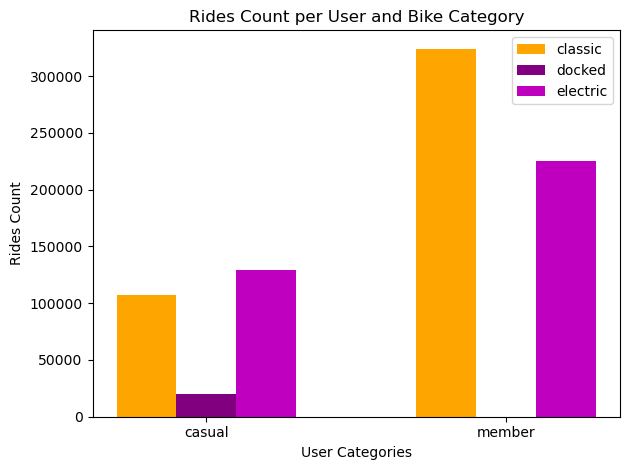

In [4]:
fig, ax = plt.subplots()
bar_width = 0.2
user_cat_idx = range(len(user_categories))

colors = ['orange','purple','m']

for i, bike_type in enumerate(bike_types):
    ax.bar([x + i * bar_width for x in user_cat_idx],[val[i] for val in bar_values],bar_width,label=bike_type,color=colors[i])

ax.set_xlabel('User Categories')
ax.set_ylabel('Rides Count')
ax.set_title('Rides Count per User and Bike Category')
ax.set_xticks([x + (len(bike_types) - 1) * bar_width / 2 for x in user_cat_idx])
ax.set_xticklabels(user_categories)
ax.legend()

plt.tight_layout()
plt.show()

## Query 2: Number of Rides and Average Ride Length per Day of the Week and User Category


In [45]:
# Define a function to get Query 2 results
def get_result():
    return db.bike_sharing_collection.aggregate([
    {
        "$group":{
           "_id":{
               "day_of_week":{"$dayOfWeek":"$start_time"},
               "user_cat":"$user_category"},
           "avg_rides_length_in_mins":{
                "$avg":{
                    "$divide": ["$ride_length_in_ms",60000]
                }
            },
            "rides_count":{"$sum":1}
        }
    },
    {
        "$project":{
            "_id":1,
            "avg_rides_length_in_mins":{
                "$ceil":"$avg_rides_length_in_mins"
            },
            "rides_count":1
        }
    },
    {   
        "$sort":{
            "_id.day_of_week":1,
            "_id.user_cat":1
        }
    }
])

# Print Query2 result
for doc in get_result():
    print(doc)

{'_id': {'day_of_week': 1, 'user_cat': 'casual'}, 'rides_count': 43575, 'avg_rides_length_in_mins': 23.0}
{'_id': {'day_of_week': 1, 'user_cat': 'member'}, 'rides_count': 60689, 'avg_rides_length_in_mins': 13.0}
{'_id': {'day_of_week': 2, 'user_cat': 'casual'}, 'rides_count': 30546, 'avg_rides_length_in_mins': 19.0}
{'_id': {'day_of_week': 2, 'user_cat': 'member'}, 'rides_count': 84876, 'avg_rides_length_in_mins': 11.0}
{'_id': {'day_of_week': 3, 'user_cat': 'casual'}, 'rides_count': 26522, 'avg_rides_length_in_mins': 16.0}
{'_id': {'day_of_week': 3, 'user_cat': 'member'}, 'rides_count': 83365, 'avg_rides_length_in_mins': 11.0}
{'_id': {'day_of_week': 4, 'user_cat': 'casual'}, 'rides_count': 31453, 'avg_rides_length_in_mins': 16.0}
{'_id': {'day_of_week': 4, 'user_cat': 'member'}, 'rides_count': 89407, 'avg_rides_length_in_mins': 11.0}
{'_id': {'day_of_week': 5, 'user_cat': 'casual'}, 'rides_count': 35339, 'avg_rides_length_in_mins': 17.0}
{'_id': {'day_of_week': 5, 'user_cat': 'member

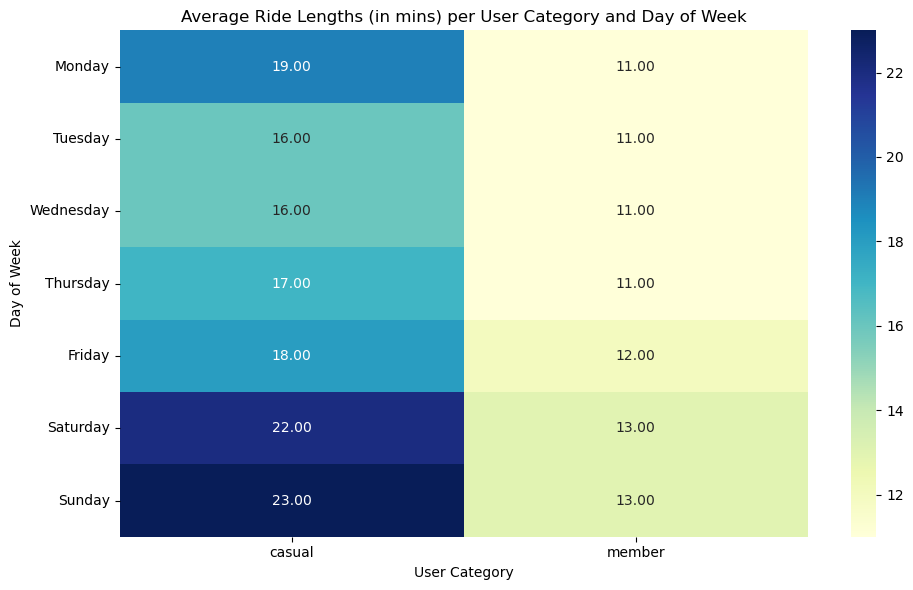

In [47]:
days_of_week = []
user_categories = []
avg_rides_length = []

# Scan documents in the result to retrieve useful information to be plotted
for doc in get_result():
    days_of_week.append(doc['_id']['day_of_week'])
    user_categories.append(doc['_id']['user_cat'])
    avg_rides_length.append(doc['avg_rides_length_in_mins'])

# Create a DataFrame to hold information extracted from the query result
data = {
    'day_of_week': days_of_week,
    'user_cat': user_categories,
    'avg_rides_length_in_mins': avg_rides_length
}

df = pd.DataFrame(data)

# Define the mapping between the number of the day of the week to its corresponding name
day_names_mapping = {1: 'Sunday', 2: 'Monday', 3: 'Tuesday', 4: 'Wednesday', 5: 'Thursday', 6: 'Friday', 7: 'Saturday'}
df['day_of_week'] = df['day_of_week'].map(day_names_mapping)

# Order the days of the week starting from Monday
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=ordered_days, ordered=True)

# Pivot the DataFrame to create a matrix suitable for creating the heatmap
pivot_df = df.pivot_table(index='day_of_week', columns='user_cat', values='avg_rides_length_in_mins', fill_value=0)

# Create the heatmap using Seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Average Ride Lengths (in mins) per User Category and Day of Week')
plt.xlabel('User Category')
plt.ylabel('Day of Week')

plt.tight_layout()
plt.show()

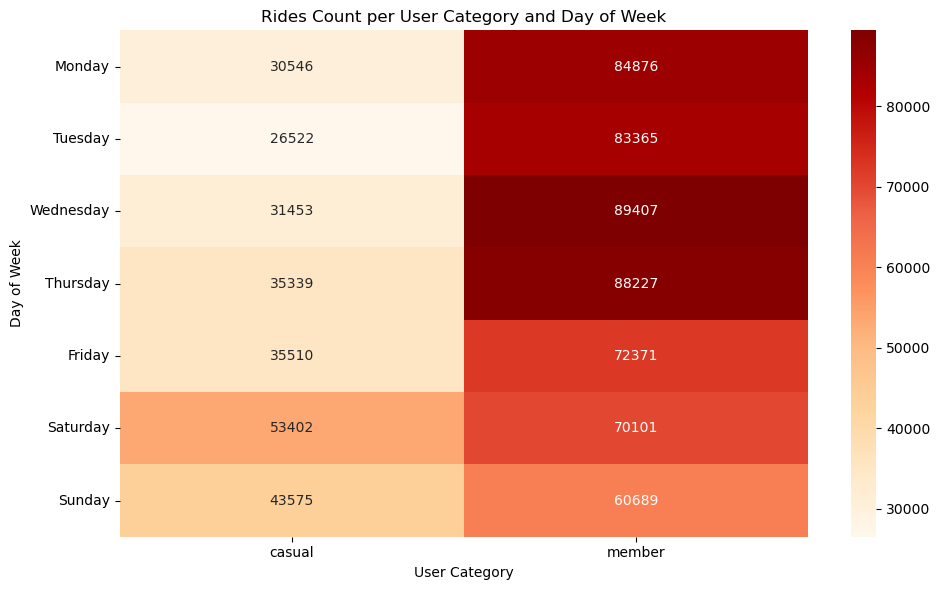

In [48]:
days_of_week = []
user_categories = []
rides_count = []

# Scan documents in the result to retrieve useful information to be plotted
for doc in get_result():
    days_of_week.append(doc['_id']['day_of_week'])
    user_categories.append(doc['_id']['user_cat'])
    rides_count.append(doc['rides_count'])

data = {
    'day_of_week': days_of_week,
    'user_cat': user_categories,
    'rides_count': rides_count
}

# Create a DataFrame to hold information extracted from the query result
df = pd.DataFrame(data)

# Define the mapping between the number of the day of the week to its corresponding name
day_names_mapping = {1: 'Sunday', 2: 'Monday', 3: 'Tuesday', 4: 'Wednesday', 5: 'Thursday', 6: 'Friday', 7: 'Saturday'}
df['day_of_week'] = df['day_of_week'].map(day_names_mapping)

# Order the days of the week starting from Monday
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=ordered_days, ordered=True)

cpivot_df = df.pivot_table(index='day_of_week', columns='user_cat', values='rides_count', fill_value=0)

# Create the heatmap using Seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df, annot=True, fmt="d", cmap="OrRd")
plt.title('Rides Count per User Category and Day of Week')
plt.xlabel('User Category')
plt.ylabel('Day of Week')

plt.tight_layout()
plt.show()

## Query 3: Hourly Distribution of Morning Rides by Day of the Week

In [51]:
# Define a function to get Query 3 results
def get_result():
    return db.bike_sharing_collection.aggregate([
    {
        "$project":{
            "_id":1,
            "day_of_week":{"$dayOfWeek":"$start_time"},
            "hour":{"$hour":"$start_time"}
        }
    },
    {
        "$match":{
            "$and":[
                {"hour":{"$gte":6}},
                {"hour":{"$lte":11}}
            ]
        }
    },
    {
        "$group": {
            "_id": {
                "day_of_week":"$day_of_week",
                "hour":"$hour",
            },
            "rides_count":{"$sum": 1}
        }
    },
    {
        "$sort":{
            "_id.day_of_week":1,
            "_id.hour":1
        }
    }
])   

# Scan documents in the result to print each docuement individually
for doc in get_result():
    print(doc)

{'_id': {'day_of_week': 1, 'hour': 6}, 'rides_count': 2503}
{'_id': {'day_of_week': 1, 'hour': 7}, 'rides_count': 4055}
{'_id': {'day_of_week': 1, 'hour': 8}, 'rides_count': 5932}
{'_id': {'day_of_week': 1, 'hour': 9}, 'rides_count': 7840}
{'_id': {'day_of_week': 1, 'hour': 10}, 'rides_count': 9028}
{'_id': {'day_of_week': 1, 'hour': 11}, 'rides_count': 8840}
{'_id': {'day_of_week': 2, 'hour': 6}, 'rides_count': 7301}
{'_id': {'day_of_week': 2, 'hour': 7}, 'rides_count': 6890}
{'_id': {'day_of_week': 2, 'hour': 8}, 'rides_count': 4538}
{'_id': {'day_of_week': 2, 'hour': 9}, 'rides_count': 4518}
{'_id': {'day_of_week': 2, 'hour': 10}, 'rides_count': 5709}
{'_id': {'day_of_week': 2, 'hour': 11}, 'rides_count': 6310}
{'_id': {'day_of_week': 3, 'hour': 6}, 'rides_count': 8526}
{'_id': {'day_of_week': 3, 'hour': 7}, 'rides_count': 7713}
{'_id': {'day_of_week': 3, 'hour': 8}, 'rides_count': 4660}
{'_id': {'day_of_week': 3, 'hour': 9}, 'rides_count': 4171}
{'_id': {'day_of_week': 3, 'hour': 1

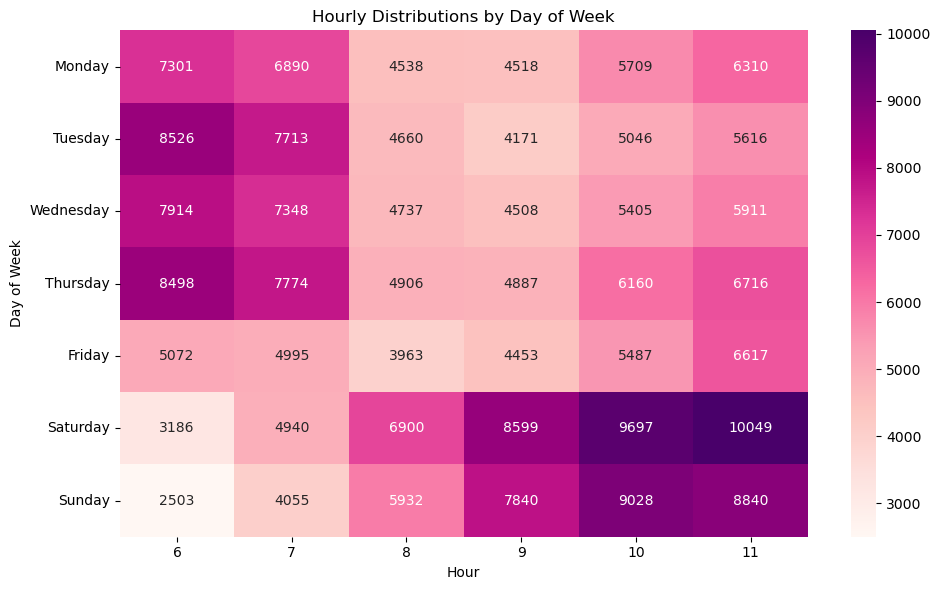

In [54]:
days_of_week = []
hours = []
rides_count = []

# Scan documents in the result to retrieve useful information to be plotted
for doc in get_result():
    days_of_week.append(doc['_id']['day_of_week'])
    hours.append(doc['_id']['hour'])
    rides_count.append(doc['rides_count'])

data = {
    'day_of_week': days_of_week,
    'hour': hours,
    'rides_count': rides_count
}

# Create a DataFrame to hold information extracted from the query result
df = pd.DataFrame(data)

# Define the mapping between the number of the day of the week to its corresponding name
day_names_mapping = {1: 'Sunday', 2: 'Monday', 3: 'Tuesday', 4: 'Wednesday', 5: 'Thursday', 6: 'Friday', 7: 'Saturday'}
df['day_of_week'] = df['day_of_week'].map(day_names_mapping)

# Order the days of the week starting from Monday
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=ordered_days, ordered=True)

# Pivot the DataFrame to create a matrix suitable for creating the heatmap
pivot_df = df.pivot_table(index='day_of_week', columns='hour', values='rides_count', fill_value=0)

# Create the heatmap using Seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df, annot=True, fmt=".0f", cmap="RdPu")
plt.title('Hourly Distributions by Day of Week')
plt.xlabel('Hour')
plt.ylabel('Day of Week')

plt.tight_layout()
plt.show()

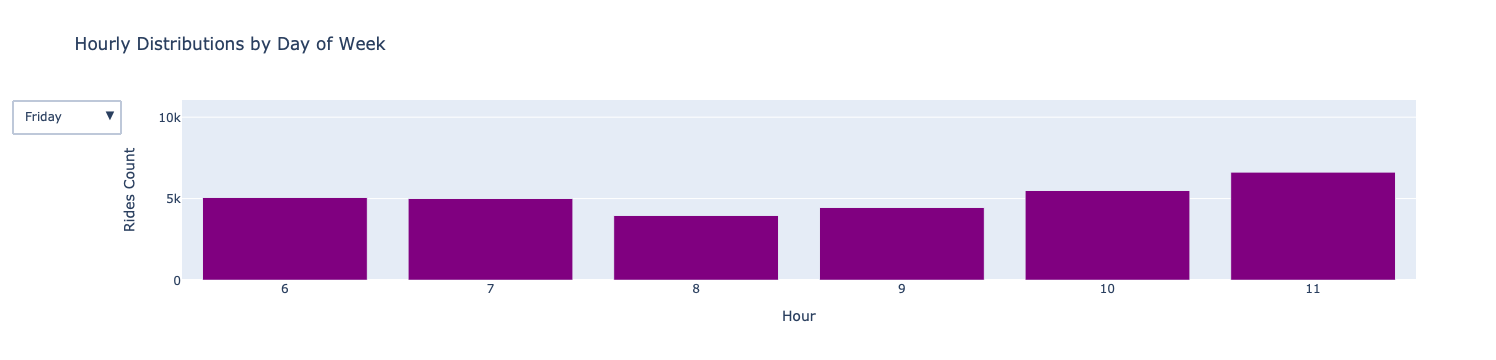

In [57]:
days_of_week = []
hours = []
rides_count = []

# Scan documents in the result to retrieve useful information to be plotted
for doc in get_result():
    days_of_week.append(doc['_id']['day_of_week'])
    hours.append(doc['_id']['hour'])
    rides_count.append(doc['rides_count'])

data = {
    'day_of_week': days_of_week,
    'hour': hours,
    'rides_count': rides_count
}

# Create a DataFrame to hold information extracted from the query result
df = pd.DataFrame(data)

# Define the mapping between the number of the day of the week to its corresponding name
day_names_mapping = {1: 'Sunday', 2: 'Monday', 3: 'Tuesday', 4: 'Wednesday', 5: 'Thursday', 6: 'Friday', 7: 'Saturday'}
df['day_of_week'] = df['day_of_week'].map(day_names_mapping)

# Pivot the DataFrame to create a matrix suitable for building the histogram
pivot_df = df.pivot_table(index='hour', columns='day_of_week', values='rides_count', fill_value=0)

# Create a list of dropdown options for days
dropdown_buttons = []
for day in pivot_df.columns:
    button = dict(method='update', label=day,
                  args=[{'y': [pivot_df[day].values], 'x': [pivot_df.index],
                         'type': 'bar', 'name': day, 'marker': {'color': 'purple'}}])
    dropdown_buttons.append(button)

layout = dict(
    title='Hourly Distributions by Day of Week',
    xaxis=dict(title='Hour'),
    yaxis=dict(title='Rides Count', range=[0, max(df['rides_count']) * 1.1]),  
    updatemenus=[dict(buttons=dropdown_buttons, direction='down', showactive=True)]
)

fig = go.Figure(data=[{'y': pivot_df[pivot_df.columns[0]].values, 'x': pivot_df.index, 'type': 'bar',
                       'marker': {'color': 'purple'}, 'name': pivot_df.columns[0]}],layout=layout)

fig.show()

## Query 4: Count of December Rides by Week

In [59]:
def get_result():
    return db.bike_sharing_collection.aggregate([
    {
        "$match":{
            "$and":[
                {"start_time":{"$gte":datetime(2022, 12, 1, 0, 0, 0)}},
                {"start_time":{"$lte":datetime(2022, 12, 31, 23, 59, 59)}}
            ]}
    },
    {
        "$group": {
            "_id": {"week_num":{"$week":"$start_time"}},
            "rides_count":{"$sum":1},
            "week_start":{"$min":"$start_time"},
            "week_end":{"$max":"$start_time"}   
        }
    },
    {
        "$project":{
            "_id":1,
            "rides_count":1,
            "number_of_days":{
                "$add":[
                    1,
                    {"$subtract":[
                        {"$dayOfYear":"$week_end"},
                        {"$dayOfYear":"$week_start"}]}]
            },
            "week_start":{
                "$dateToString":{
                    "format":"%Y-%m-%d","date":"$week_start"}},
            "week_end":{
                "$dateToString":{
                    "format":"%Y-%m-%d","date":"$week_end"}}
        }
    },
    {
        "$sort":{"_id.week_num":1}
    }])

for doc in get_result():
    print(doc)

{'_id': {'week_num': 48}, 'rides_count': 19133, 'number_of_days': 3, 'week_start': '2022-12-01', 'week_end': '2022-12-03'}
{'_id': {'week_num': 49}, 'rides_count': 44760, 'number_of_days': 7, 'week_start': '2022-12-04', 'week_end': '2022-12-10'}
{'_id': {'week_num': 50}, 'rides_count': 33301, 'number_of_days': 7, 'week_start': '2022-12-11', 'week_end': '2022-12-17'}
{'_id': {'week_num': 51}, 'rides_count': 18458, 'number_of_days': 7, 'week_start': '2022-12-18', 'week_end': '2022-12-24'}
{'_id': {'week_num': 52}, 'rides_count': 19707, 'number_of_days': 7, 'week_start': '2022-12-25', 'week_end': '2022-12-31'}


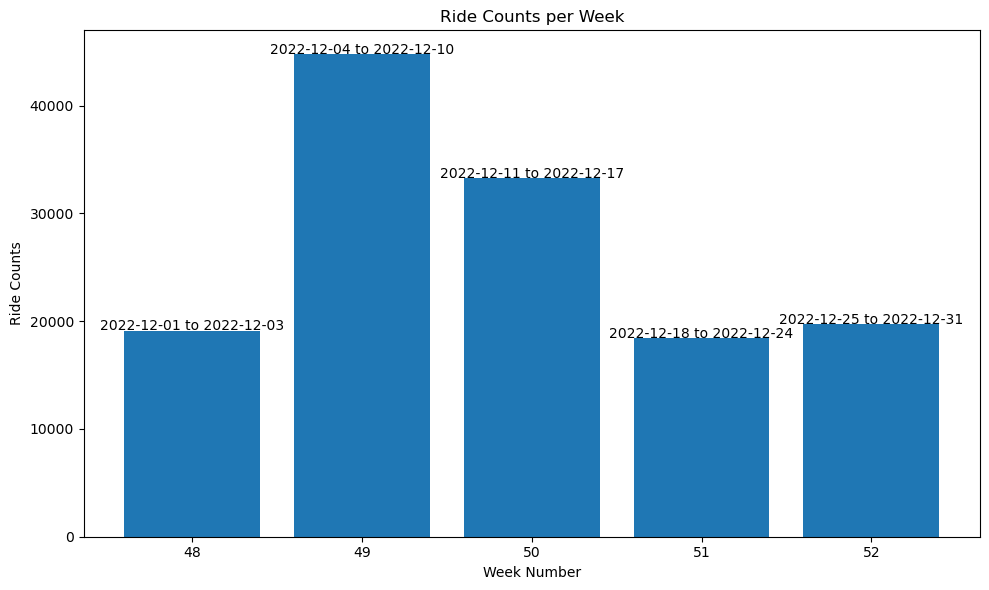

In [60]:
weeks = []
ride_counts = []
week_starts = []
week_ends = []

# Scan documents in the result to retrieve useful information to be plotted
for doc in get_result():
    weeks.append(doc['_id']['week_num'])
    ride_counts.append(doc['rides_count'])
    week_starts.append(doc['week_start'])
    week_ends.append(doc['week_end'])

plt.figure(figsize=(10, 6))
plt.bar(weeks, ride_counts)
plt.xlabel('Week Number')
plt.ylabel('Ride Counts')
plt.title('Ride Counts per Week')

for i in range(len(weeks)):
    plt.text(weeks[i], ride_counts[i] + 10, f"{week_starts[i]} to {week_ends[i]}", ha='center')

plt.tight_layout()
plt.show()